# A reactor core example with hexagonal lattices: 

This notebook provide an example of a nuclear thermal propulsion reactor with two levels of hexagonal lattices.

This example is one of the NERVA reactors, as illustrated in this document:
https://nuke.fas.org/space/la-10062.pdf

Fuel assemblies are arranged in a hexagonal lattice and surrounded by a beryllium reflector.
Each fuel assembly has a hexagonal lattice for its coolant channel.

First, let us import the necessary python modules.

In [1]:
import tripoli5
from tripoli5.core.euclide import Point, Vector
from tripoli5.core.literals import K
import numpy as np
import matplotlib.pyplot as plt

## Cells definition

The reactor is made of two types of assemblies: 

-   **Fuel element** : UC-ZrC composite matrix drilled with coolant channels
-   **Tie tubes** : structural elements containing a moderator layer.

### Tie tube

A tie tube is a structural element containing co-centric tubes as follows:

![Tie tube](img/tie_tube_picture.PNG)

In this example, the tie tube outer cladding is not modelled.  
First let us define the dimensions useful in this Tie Tube cell. 

In [2]:
h2_supply_radius = 0.419 / 2
# Tie tube inner H2 chanel radius
inner_tie_radius = 0.521 / 2
# Tie tube steel radius
gap1_radius = 0.533 / 2
# Tie tube inner gap outer radius
mod_radius = 1.168 / 2
# Tie tube moderator radius
h2_return_radius = 1.397 / 2 - 0.0205
# Tie tube outer H2 chanel radius
outer_tie_radius = 1.397 / 2
# Tie tube outer gap radius
coat_radius = 1.613 / 2
# Tie tube coat radius
gap2_radius = 1.639 / 2
# Tie tube graphite radius

Then we can define a layer in the x-y plane.

In [3]:
#   Creation of the concentric cylinders defining the geometry
h2_supply_region = tripoli5.agora.ZCylinder(0.0, 0.0, h2_supply_radius)
inner_region = tripoli5.agora.ZCylinder(0.0, 0.0, inner_tie_radius)  # inner tie tube
gap1_region = tripoli5.agora.ZCylinder(0.0, 0.0, gap1_radius)
ZrH_mod_region = tripoli5.agora.ZCylinder(0.0, 0.0, mod_radius)
h2_return_region = tripoli5.agora.ZCylinder(0.0, 0.0, h2_return_radius)
outer_region = tripoli5.agora.ZCylinder(0.0, 0.0, outer_tie_radius)  # outer tie tube
coat_region = tripoli5.agora.ZCylinder(0.0, 0.0, coat_radius)
gap2_region = tripoli5.agora.ZCylinder(0.0, 0.0, gap2_radius)

#   Definition of the shapes between the cylinders
h2_supply_shape = tripoli5.agora.Shape(-h2_supply_region)
inner_shape = tripoli5.agora.Shape(-inner_region & h2_supply_region)  # inner tie tube
gap1_shape = tripoli5.agora.Shape(-gap1_region & inner_region)
ZrH_mod_shape = tripoli5.agora.Shape(-ZrH_mod_region & gap1_region)
h2_return_shape = tripoli5.agora.Shape(-h2_return_region & ZrH_mod_region)
outer_shape = tripoli5.agora.Shape(-outer_region & h2_return_region)  # outer tie tube
coat_shape = tripoli5.agora.Shape(-coat_region & outer_region)
gap2_shape = tripoli5.agora.Shape(-gap2_region & coat_region)
outside_shape = tripoli5.agora.Shape(gap2_region)

#   Creation of the volumes, associating the shapes to their materials
v1 = tripoli5.agora.Volume(h2_supply_shape, "H2_supply")
v2 = tripoli5.agora.Volume(inner_shape, "Inner_tie_tube")
v8 = tripoli5.agora.Volume(gap1_shape, "Gap")
v3 = tripoli5.agora.Volume(ZrH_mod_shape, "Moderator")
v4 = tripoli5.agora.Volume(h2_return_shape, "H2_return")
v5 = tripoli5.agora.Volume(outer_shape, "Outer_tie_tube")
v6 = tripoli5.agora.Volume(coat_shape, "Coat")
v9 = tripoli5.agora.Volume(gap2_shape, "Gap")
v7 = tripoli5.agora.Volume(outside_shape, "Graphite")

The geometry contained in the hexagonal assemblies are then stored in universes. We create here an infinite universe containing our concentric cylinders. Once this universe is set in a lattice cell, it will be cropped to the hexagonal lattice cell shape.

In [4]:
tie_tube_universe = tripoli5.agora.Universe([v1, v2, v3, v4, v5, v6, v7, v8, v9])
tie_volume = tripoli5.agora.CompositeVolume(
    tripoli5.agora.Shape.infinite(), filler=tie_tube_universe
)
tie_universe = tripoli5.agora.Universe([tie_volume])

Below we plot the Tie tube 

In [5]:
tie_tube_geom = tripoli5.agora.Geometry(tie_universe)
plotter = tripoli5.geoplotter.GeoPlotterPyplot(tie_tube_geom)

frame = tripoli5.geoplotter.Frame.fromMinMax(
    "XY", altitude=0.0, u_min=-1.2, u_max=1.2, v_min=-1.2, v_max=1.2
)
_ = plotter.plot(frame=frame, resolution=250)

### Fuel element

A fuel element consists in a hexagon drilled with holes arranged in a hexagonal pattern to let the coolant go through the assembly. 

![Fuel element](img/fuel_element_picture.PNG)


First let us define the dimensions useful in this fuel cell. 

In [6]:
# Coolant chanel radius
h2_radius = 0.254 / 2
# Holes radius including the coating.
h2_coat_radius = h2_radius + 0.01
#  Pitch between two fuel elements (define the size of the assembly lattice).
hexagon_pitch = 1.913
# Width of the coating surrounding the fuel element.
coat_width = 0.01
# Pitch between two holes in the holes lattice.
hexagon_pitch_lattice = 0.4
# Height of the fuel element. As the geometry is 2D, 0 is used.
fuel_elem_height = 0.0
# Number of rings in which the cooland holes are arranged.
nb_rings = 3
# Width of the fuel hexagon without its surrounding cladding
width = (hexagon_pitch / 2) - coat_width

Then we can define a layer in the x-y plane.

In [7]:
#   Coolant channel and associated coating surfaces and shapes
s1 = tripoli5.agora.ZCylinder(0.0, 0.0, h2_radius)
s2 = tripoli5.agora.ZCylinder(0.0, 0.0, h2_coat_radius)

shape1 = tripoli5.agora.Shape(-s1)  # inside the cylinder of H2
shape2 = tripoli5.agora.Shape(-s2 & +s1)  # inside the small coat of ZrC
shape3 = tripoli5.agora.Shape(s2)  # outside

#   Definition of each volume associated to their materials
v1 = tripoli5.agora.Volume(shape1, f"H2_comb")
v2 = tripoli5.agora.Volume(shape2, f"Coat")
v3 = tripoli5.agora.Volume(shape3, f"Fuel")  #   Outside world

#   Coolant chanel and its surrounding fuel
cool_universe = tripoli5.agora.Universe([v1, v2, v3])

Now we can define the lattice of the coolant channels for a single fuel assembly

In [8]:
center_point = Point(0.0, 0.0, 0.0)
background_universe = tripoli5.agora.createInfinite(material=f"Fuel")

hex_lattice = tripoli5.agora.HexLattice(
    point=center_point,
    hex_pitch=hexagon_pitch_lattice,
    axial_pitch=fuel_elem_height,
    nb_rings=nb_rings,
    n_axial=0,
    universe=cool_universe,
    outer_universe=background_universe,
    label="Coolant_19_lattice",
)

For plotting purposes only, we can create a universe and a geometry containing the above lattice

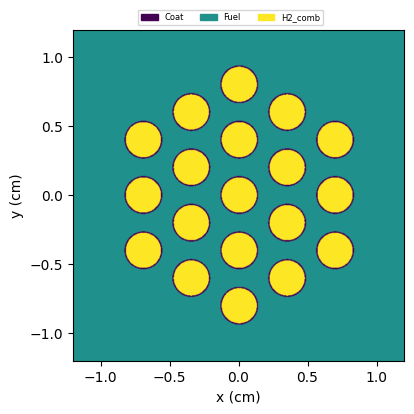

In [9]:
lattice_volume = tripoli5.agora.CompositeVolume(
    tripoli5.agora.Shape.infinite(), filler=hex_lattice
)
fuel_universe = tripoli5.agora.Universe([lattice_volume])
fuel_geom = tripoli5.agora.Geometry(fuel_universe)
plotter = tripoli5.geoplotter.GeoPlotterPyplot(fuel_geom)

frame = tripoli5.geoplotter.Frame.fromMinMax(
    "XY", altitude=0.0, u_min=-1.2, u_max=1.2, v_min=-1.2, v_max=1.2
)
_ = plotter.plot(frame=frame, resolution=250)

Then we can construct the fuel volume by truncating the previously defined lattice.
Here the hexagonal coating of the cell is defined using a set of planes

In [10]:
#   Definition of planes limitting the fuel hexagon, limit between the fuel and its outer coating
ur = tripoli5.agora.Plane(np.sqrt(3) / 2, 0.5, 0, width)  # upper right
ul = tripoli5.agora.Plane(-np.sqrt(3) / 2, 0.5, 0, -width)  # Upper left
bl = tripoli5.agora.Plane(-np.sqrt(3) / 2, -0.5, 0, width)  # bottom left
br = tripoli5.agora.Plane(np.sqrt(3) / 2, -0.5, 0, -width)  # bottom right
up = tripoli5.agora.YPlane(width)
down = tripoli5.agora.YPlane(-width)

#   Shape delimiting the fuel matrix (the coating is outside this shape)
hex_box_region = -bl & ul & -up & -ur & br & down

#   As we can see in the plot above, the holes are arranged in a hexagone tilted by 90 degrees compared to the lattice element, a rotation is added through an affine transformation
rot = tripoli5.core.euclide.Rotation(Vector(0.0, 0.0, 90.0))
transf = tripoli5.core.euclide.AffineTransformation(None, rot)

shape_in = tripoli5.agora.Shape(hex_box_region)  # in the box
shape_out = tripoli5.agora.Shape(-hex_box_region)  # outside the box

lattice_volume = tripoli5.agora.CompositeVolume(
    shape_in, filler=hex_lattice, affinetransformation=transf
)
coat_volume = tripoli5.agora.Volume(shape_out, material=f"Coat")

fuel_element_universe = tripoli5.agora.Universe([lattice_volume, coat_volume])

Then we can plot the fuel element

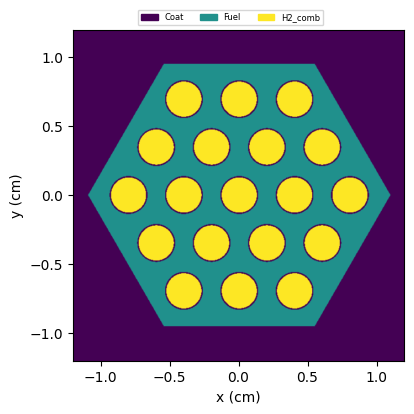

In [11]:
fuel_element_geom = tripoli5.agora.Geometry(fuel_element_universe)
plotter = tripoli5.geoplotter.GeoPlotterPyplot(fuel_element_geom)

frame = tripoli5.geoplotter.Frame.fromMinMax(
    "XY", altitude=0.0, u_min=-1.2, u_max=1.2, v_min=-1.2, v_max=1.2
)
_ = plotter.plot(frame=frame, resolution=250)

## Reactor hexagonal lattice

Now that the two types of cells are defined, they can be positioned in a hexagonal lattice as displayed in the following figure

![Core hexagonal lattice](img/hexagonal_lattice.PNG)

![Core hexagonal lattice](img/transverse_section_reflector.PNG)

Here are the specifications of the hexagonal lattice

In [12]:
reactor_height = 0.93
core_radius = 28.5
nb_rings = 21
nb_axial = 0

A hexagonal lattice is first created and filled with fuel elements. The tie tubes universes are then individually placed at their positions using a for loop. Beyond a certain radius, the assemblies are filled with graphite to transition from the core to the reflector. 

We first start this section by creating an infinite graphite universe.

In [13]:
graphite_element = tripoli5.agora.ZCylinder(0.0, 0.0, 4)

sh_gr = tripoli5.agora.Shape(-graphite_element)
outside_gr = tripoli5.agora.Shape(graphite_element)

gr_vol = tripoli5.agora.Volume(sh_gr, "Graphite")
outside_gr_vol = tripoli5.agora.Volume.outside(outside_gr)

graphite_universe = tripoli5.agora.Universe([gr_vol, outside_gr_vol])

In [14]:
center_point = Point(0.0, 0.0, 0.0)
background_universe = tripoli5.agora.createInfinite(material="Graphite")

geom_lattice = tripoli5.agora.HexLattice(
    point=center_point,
    hex_pitch=hexagon_pitch,  # pitch of the hexagon
    axial_pitch=reactor_height,  # height of the hexagon
    nb_rings=nb_rings,  # number of rings
    n_axial=nb_axial,  # numero di strati
    universe=fuel_element_universe,
    outer_universe=background_universe,
    label="lattice_of_the_core",
)


min_range_value = -nb_rings + 1
max_range_value = nb_rings

"""
    Here we loop on the assemblies to fill the non-fuel elements by their respective universes.

    the central number is the diagonal number (starting from 0)
    the number on the left is the position with respect to the center position
"""

for j in range(min_range_value, max_range_value):
    for i in range(min_range_value, max_range_value):
        # We set the assembly if it is within a given range (to not set out of range)
        if abs(i + j) < max_range_value:
            if i == 0:
                distance_cells = hexagon_pitch * abs(j)
            elif j == 0:
                distance_cells = hexagon_pitch * abs(i)
            elif i * j > 0:
                distance_cells = hexagon_pitch * np.sqrt(
                    i**2 + j**2 - 2 * i * j * np.cos(2 * np.pi / 3)
                )
            else:
                distance_cells = hexagon_pitch * np.sqrt(
                    i**2 + j**2 + 2 * i * j * np.cos(np.pi / 3)
                )

            # In the reference reactor, the tie tubes are all surrounded by fuel elements
            # This tests allows setting on the same pattern
            if ((j % 2) == 0 and ((i - j) % 3) == 0) or (
                ((j + 1) % 2) == 0 and (i - (j - 3)) % 3 == 0
            ):
                geom_lattice[i, j, 0] = tie_tube_universe

            # If we are beyond a certain radius, the assemblies are filled with graphite (transition to the reflector)
            if distance_cells >= (core_radius):
                geom_lattice[i, j, 0] = graphite_universe

We can plot the global lattice.  
As the plotter accepts a `plt.Axes`, we can use it for subplotting. 

In [15]:
lattice_volume = tripoli5.agora.CompositeVolume(
    tripoli5.agora.Shape.infinite(), filler=geom_lattice
)
fuel_universe = tripoli5.agora.Universe([lattice_volume])
fuel_element_geom = tripoli5.agora.Geometry(fuel_universe)
plotter = tripoli5.geoplotter.GeoPlotterPyplot(fuel_element_geom)

frame_global = tripoli5.geoplotter.Frame.fromMinMax(
    "XY", altitude=0.0, u_min=-35, u_max=35, v_min=-35, v_max=35
)
frame_local = tripoli5.geoplotter.Frame.fromMinMax(
    "XY", altitude=0.0, u_min=-3, u_max=3, v_min=-3, v_max=3
)

fig, axs = plt.subplots(ncols=2)
_ = plotter.plot(frame=frame_global, resolution=20, ax=axs[0])
_ = plotter.plot(frame=frame_local, resolution=200, ax=axs[1])
plt.tight_layout()

## Placing the fuel matrix in its reflector

A reflector can now be set around the core lattice. In this example, the reflector was simplified to a cylinder of beryllium.

In [16]:
hexagon_pitch = 1.913
reactor_height = 88.9
ref_inner_radius = 33.65
ref_thick = 14.7

The reactor is built using three shapes:
-   core_shape : inside the inner radius of the reflector will be filled with the core lattice
-   reflector_shape : the region between the inner and outer reflector radii will be filled with beryllium
-   outside_shape : outside the outer radius of the reflector will be filled with the outside world, marking the end of the geometry

In [17]:
s3 = tripoli5.agora.ZCylinder(0.0, 0.0, ref_inner_radius)
s6 = tripoli5.agora.ZCylinder(0.0, 0.0, ref_inner_radius + ref_thick)

core_shape = tripoli5.agora.Shape(-s3)

ref_region = s3 & -s6
ref_shape = tripoli5.agora.Shape(ref_region)

outside_shape = tripoli5.agora.Shape(s6)

# Creation of a volume containing the global lattice inside the core shape
lattice_volume1 = tripoli5.agora.CompositeVolume(core_shape, filler=geom_lattice)

# Reflector volume
reflector_volume = tripoli5.agora.Volume(ref_shape, "Reflector")

# Outside of the geometry
outside = tripoli5.agora.Volume.outside(outside_shape)

geom_universe = tripoli5.agora.Universe([lattice_volume1, reflector_volume, outside])

final_geom = tripoli5.agora.Geometry(geom_universe)

The complete geometry finally looks like

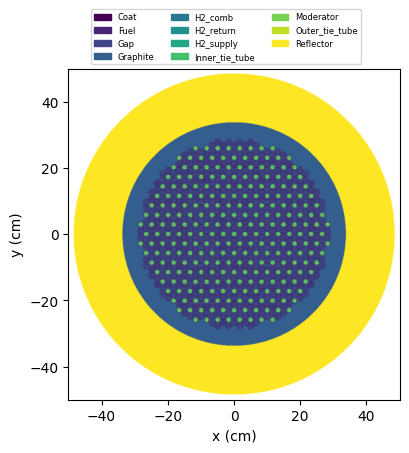

In [18]:
plotter = tripoli5.geoplotter.GeoPlotterPyplot(final_geom)

frame = tripoli5.geoplotter.Frame.fromMinMax(
    "XY", altitude=0.0, u_min=-50, u_max=50, v_min=-50, v_max=50
)
_ = plotter.plot(frame=frame, resolution=10)